# Mission Simulation
Scripts to simulate the behaviour and conditions of the satellite in different orbits, under different plans of operation.

### 0. Setup and Global Constants

In [53]:
# 0.1 Imports
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import os.path
import datetime as dt

In [2]:
# 0.2 Physical Constants
o = 5.67*np.power(10.0,-8.0);     #Stephan-Boltzmann Constant

### 1. Orbital Inputs
Every orbit from STK can be imported as a class

In [45]:
class Orbit (object):

    # wb_name [string] - name of the Excel workbook containing beta angles and exlipse fractions
    # sh_name [string] - name of the sheet to look at in the owrkboo
    def __init__(self, wb_name, sh_name, n_days, T, alt, launch_date):
        # Allocate arrays
        self.beta_angles = np.zeros(n_days + 1)
        self.eclipse_frc = np.zeros(n_days + 1) 
        self.launch_date = launch_date
        self.T_orbit = T;
        self.alt = alt
        # CAUTION: beta_angles[0] and eclipse_frc[0] are ignored. Day 1, the first day, is stored in [1]

        # Import notebook (no formulas, data only)
        wb = load_workbook(wb_name, data_only=True)

        # Loop through each day
        row = 2
        while (wb[sh_name]["D"+str(row)].value != None):
            self.beta_angles[row - 1] = wb[sh_name]['E'+str(row)].value
            self.eclipse_frc[row - 1] = wb[sh_name]['G'+str(row)].value
            row += 1
    

### 2. Satellite Properties

Here we define the satellite properties, concept of operations and other operational parameters that simulate our satellite.

#### 2.1 Satellite constants and Assumptions
Assumptions and constants regarding the thermal properties, time between radio tranmissions and power generation from solar panels

In [4]:
# 1.1 Define Class of Thermal Properties
class THM_Properties(object):
    def __init__(self):
        return
    # Thermal Assumptions
    tot = 0.1418;           #Total Area [m^2]
    a = 0.72;               #Absorptivity 
    e = 0.58;               #Emissivity
    Ra = 0.1;               #Absorptivity
    Re = 0.8;               #Emissivity
    Arad = 0;               #Area of Radiator [m^2]
    K = 0.06;               #Bus-Payload Conductance [W/K]
    Pmax = 0.2;             #Max heat disipation 
    
    sta_coldT = 10          # Minimum temperature during stasis [C]
    exp_coldT = 33          # Minimum temperature during experiment [C]
    

In [5]:
# 1.2 Define communication time and length
class COM_Properties(object):
    def __init__(self):
        return
    beacon_time = 1        # length of a beacon transmission in minutes
    tx_time = 1            # length of a transmission in minutes
    beacon_per_orbit = 5   # Number of beacons in an orbit
    tx_per_orbit = 1       # Number of transmissiosn in an orbit

In [6]:
# 1.3 Define Power Generation / solar cell Properties
class PWR_Gen_Properties(object):
    def __init__(self):
        return
    pwr_in_sun = 6000 #Power generated in the sun, mW (extracted from Sam's old datasheets)
    eff = 0.75 # efficiency

#### 2.4 CONOPS
This can be improved upon to decide the operational principles of the satellite. Currently only has a predefined start date and experiment length.

In [7]:
class CONOPS(object):
    def __init__(self):
        return
    mission_len = 100 # days
    exp_len = 5 #days
    exp_start = 30 #days

#### 2.5 Component Class
Every component that consumes power is instantiated as an object with a dictionary containing its power usage at different states

In [8]:
class Component(object):
    def __init__ (self, name, states):
        # name: a descriptive string
        self.name = name
        # states: a dictionary describing possible states of the form: {'state_name' : [nominal_power, budgeted_power]}
        # units are mW
        self.states = states
    def pwr(self,state, val = 1):
        return self.states[state][val]
    def change_pwr(self, state, update, val=1):
        self.states[state][val] = update

#### 2.6 Bus and Payload Objects
Grouping the components together. 
The bus contains the OBC, EPS, and COM boards as well as the Li-1 Transceiver.
Pay contains the heaters, payload microcontroller, and eps_htr which is the converter running during the operation of the heaters - EPS consumes more power during heating according to Sam's budgets.


In [9]:
class Bus(object):
    def __init__ (self, state, com_properties, orb_properties, obc, eps, com, li1):
        self.com_p = com_properties
        self.orb_p = orb_properties
        
        self.obc = obc
        self.eps = eps
        self.com = com
        self.li1 = li1
        
        self.state = state
        
        self.set_power()

    
    def set_state(self, state):
        self.state = state
        self.set_power()
            
    def set_power(self):
        self.pwr = (self.com_p.beacon_per_orbit / self.orb_p.T_orbit) * self.com_p.beacon_time * self.li1.pwr("TX")
        self.pwr += (self.com_p.tx_per_orbit / self.orb_p.T_orbit) * self.com_p.tx_time * self.li1.pwr("TX")
        self.pwr += ((1 - (self.com_p.tx_per_orbit * self.com_p.tx_time + self.com_p.beacon_per_orbit * self.com_p.beacon_time)) / self.orb_p.T_orbit) * self.li1.pwr("RX")
        
        self.pwr += self.obc.pwr(self.state)
        self.pwr += self.com.pwr(self.state)
        self.pwr += self.eps.pwr(self.state)
        
        
        
class Pay(object):
    def __init__ (self,state, ssm, htr, eps_htr):
        self.state = state
        
        self.ssm = ssm
        self.htr = htr
        self.eps_htr = eps_htr
        
        self.set_power()
        
    def set_heat (self, heat_sta, heat_exp):
        self.htr.change_pwr("KPALIVE", heat_sta, 0)
        self.htr.change_pwr("KPALIVE", heat_sta * 1.1, 1)
        self.htr.change_pwr("EXP", heat_exp, 0)
        self.htr.change_pwr("EXP", heat_exp * 1.1, 1)
        self.set_power()
    
    def set_state (self, state):
        self.state = state
        self.set_power()
    
    def set_power(self):
        self.pwr = self.ssm.pwr(self.state)
        self.pwr += self.htr.pwr(self.state)
        self.pwr += self.eps_htr.pwr(self.state)

#### 2.7 Satellite Object
Brings everything together. Contains methods to simulate the orbit.

In [219]:
class Satellite (object):
    # Inputs: Orbit, THM_Properties, #PWR__Gen_Properties, Bus, Payload
    def __init__ (self, o, t_p, c_p, p_p, bus, payload):
        self.pwr_gen = p_p.pwr_in_sun * p_p.eff * (1 - o.eclipse_frc)
        self.bus = bus
        self.payload = payload
        self.orb_prop = o
        self.thm_prop = t_p
        self.com_prop = c_p
        self.pay_prop = p_p
        return
        
    def simulate (self, conops):
        heats = get_heats(self.thm_prop, self.orb_prop)
        self.exp_heats = heats[0]
        self.sta_heats = heats[1]
        
        
        self.pwr_out= np.zeros(conops.mission_len + 1)
        self.margin = np.zeros(conops.mission_len + 1)
        self.dates = [0]
        
        
        for i in range(1,conops.mission_len + 1):
            if ( i < conops.exp_start or i > (conops.exp_start + conops.exp_len - 1) ):
                self.bus.set_state('REGULAR')
                self.payload.set_state('KPALIVE')
            else:
                self.payload.set_state('EXP')
                self.bus.set_state('REGULAR')
                
            self.payload.set_heat(self.sta_heats[i], self.exp_heats[i])
            
            self.pwr_out[i] = self.bus.pwr + self.payload.pwr
            self.margin[i] = - self.pwr_out[i] + self.pwr_gen[i]
            
            self.dates.append(self.orb_prop.launch_date + (i-1)*dt.timedelta(days=1))
            
        self.plot()
        
        return
    
    def plot(self):
        
        plt.figure(figsize=(12, 6))
        
        plt.ylabel ("Power (mW)")
        plt.xlabel ("Date")
        
        gen = plt.plot(self.dates[1:], self.pwr_gen[1:len(self.dates)], 'g', label='Power Generated')
        out = plt.plot(self.dates[1:], self.pwr_out[1:len(self.dates)], 'b', label='Power Consumed')
        mar = plt.plot(self.dates[1:], self.margin[1:len(self.dates)], 'r', label='Margin')
  
        plt.legend ()
        plt.ylim ((0,5000))
        plt.show()
            

### 3. Thermal Requirements
Heating requirements for Stasis and Experiment based on orbit. Taken from Joanna's MATLAB simulation. 

In [220]:
def get_heats(thm_p, orb_p):
    #3.1 Define Constants 

    #target temperatures
    exp_minT = thm_p.exp_coldT
    sta_minT = thm_p.sta_coldT

    tot = thm_p.tot           #Total Area [m^2]
    a = thm_p.a               #Absorptivity 
    e = thm_p.e               #Emissivity
    Ra = thm_p.Ra             #Absorptivity
    Re = thm_p.Re             #Emissivity
    Arad = thm_p.Arad         #Area of Radiator [m^2]
    K = thm_p.K               #Bus-Payload Conductance [W/K]
    Pmax = thm_p.Pmax         #Max heat disipation 
    
    #3.2 Read Data
    Bdegs = np.abs(orb_p.beta_angles)
    Ef    = orb_p.eclipse_frc
    Brad = Bdegs/180*np.pi


    #3.3 Empty Arrays
    Tcold = np.zeros(n_days+1)
    heatExp = np.zeros(n_days+1)
    heatSta = np.zeros(n_days+1)

    for i in range (1, n_days):
        #2.4.1 Albedo Correction
        Bd = Bdegs[i]
        if Bd > 0 and Bd < 20:
            c = Bd*(0.05 - 0.04)/20 + 0.04;
        elif Bd > 20 and Bd < 40:
            c = (Bd - 20)*(0.07 - 0.05)/20 + 0.05;
        elif Bd > 40 and Bd < 50:
            c = (Bd - 40)*(0.09 - 0.07)/10 +0.07;
        elif Bd > 50 and Bd < 60:
            c = (Bd - 50)*(0.12 - 0.09)/10 + 0.09;
        elif Bd > 60 and Bd < 70:
            c = (Bd - 60)*(0.16 - 0.12)/10 + 0.12; 
        elif Bd > 70 and Bd < 80:
            c = (Bd - 70)*(0.22 - 0.16)/10 + 0.16;
        else:
            c = (Bd - 80)*(0.31 - 0.22)/10 + 0.22;

        #3.4.2 Heat Flux Constants (Taken from SSO analysis matlab file, is it supposed to be different for ISS?)
        F = [0.0265, 1322.0, 217.0, 0.17+c]

        #3.4.3 Select and calculate extreme cases for each week
        coldT = np.power(o,-0.25) * np.power((F[1] * (a/e) * ( (1.0-Ef[i]) * (F[0]/tot) + 
                                               np.cos(Brad[i])/np.power((np.pi),2.0)*F[3]) 
                                                + F[2]/np.pi),(0.25)) - 10.0
        #3.5 Populate Array
        Tcold[i] = coldT
        heatExp[i] = (K*(exp_minT+273.15-coldT)) + (Arad*o*Re*(np.power(coldT,4) - np.power(4,4)))-Pmax
        heatSta[i] = (K*(sta_minT+273.15-coldT)) + (Arad*o*Re*(np.power(coldT,4) - np.power(4,4)))-Pmax

     # Convert Everything into mW
    
        
    return (1000*heatExp, 1000*heatSta)

### Simulate

In [221]:
# 1. Set up orbit
# Excel Workbook of Beta Angles and Eclipse Fractions, must be in same directory
wb_name = 'July19_July20ISS.xlsx'
sh_name = 'ISS Beta Angles'
n_days = 397
launch = dt.date(2019, 7, 1)

orb_prop = Orbit(wb_name, sh_name, 397, 1.54*60, 550, launch)

In [222]:
# 2. Set up properties as default values

thm_prop = THM_Properties()
com_prop = COM_Properties()
gen_prop = PWR_Gen_Properties()
conops = CONOPS()

In [223]:
# 3. Set up components and power usage
obc_ssm = Component("OBC",    {'REGULAR'  : [50, 55],
                              'LOPWR'     : [30, 33]})
 
eps_ssm = Component("EPS",    {'REGULAR' :  [50,55],
                               'LOPWR'   :  [50,55]})

eps_htr = Component ("EPS_HTR",{'KPALIVE' :  [150, 157.5],
                               'EXP'     :  [150, 157.5]})

com_ssm = Component("COM",    {'REGULAR' :  [50,55] })

com_li1 = Component("Li-1",   {'RX'      :  [200, 250],
                               'TX'      :  [10000, 10000]})
  
pay_ssm = Component("PAY",    {'KPALIVE' :  [50,55],
                               'EXP'     :  [200,210]})

pay_htr = Component("HEATER", {'KPALIVE' :  [0, 0],
                               'EXP'     :  [0, 0],
                               'OFF'     :  [0, 0]})

In [224]:
# 4. Create a payload and Bus
payload = Pay("KPALIVE", pay_ssm, pay_htr, eps_htr)
bus = Bus("REGULAR", com_prop, orb_prop, obc_ssm, eps_ssm, com_ssm, com_li1)

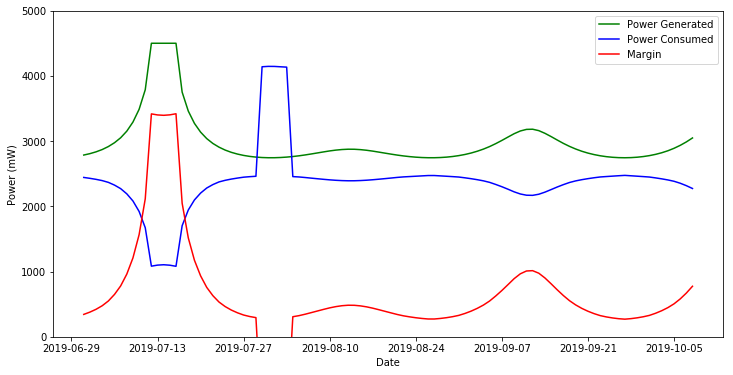

In [225]:
# 5. Create Satellite and Simulate
HeronMkII = Satellite(orb_prop, thm_prop, com_prop, gen_prop, bus, payload)
HeronMkII.simulate(conops)

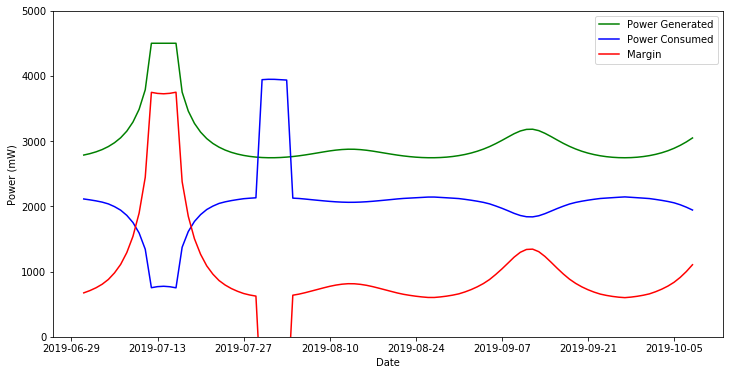

In [226]:
# Try changing the temperature goals and try again: 
HeronMkII.thm_prop.exp_coldT = 30
HeronMkII.thm_prop.sta_coldT = 5
HeronMkII.simulate(conops)

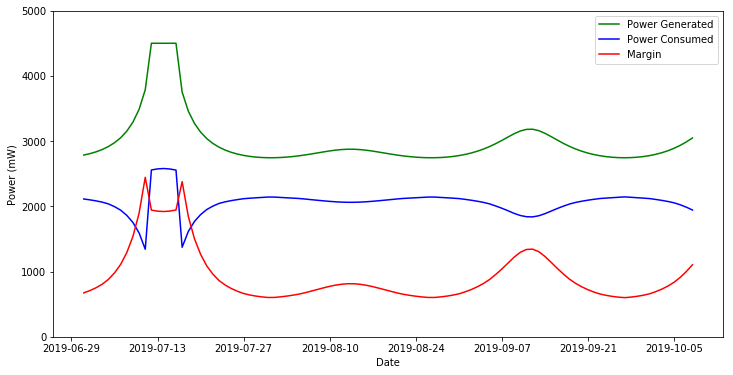

In [228]:
# Change conops plan and try again:
conops.exp_start = 12
HeronMkII.simulate(conops)